# Multivariate Newton method

We now know from the basic idea behind Newton's method and how to implement it simply in `python`, in the case of function of a real variable. \
However, problems in continuum mechanics often involve systems of equations and/or vector/tensor variables. In this tutorial, we will walk through a simple 2D case: 2 unknowns, 2 equations. \
We will consider two planar curves, of following equations:

$$ 
(E) : \left\{
\begin{array}{}
f_1(x_1,x_2) = \left(x_1-\frac{1}{2}\right)^2 + 2\left(x_2+\frac{1}{2}\right)^2 - 1, \\
f_2(x_1,x_2) = \cos(x_2)x_1^2 + \cos(x_1)x_2^2 - \frac{1}{2}.
\end{array}
\right.
$$

$f_1$ is the equation to an ellipse and $f_2$ to an ellipse modified with a cosinus factor. Solving this system of equations amounts to finding the intersection between these two ellipse-like curves in the $(x_1,x_2)$ plane. \
Let us first define the two functions $f_1$ and $f_2$ and plot the two curves. For this, we will use a `contour` plot and display only the contour corresponding to a value of the function equal to 0.

Text(0, 0.5, '$x_2$')

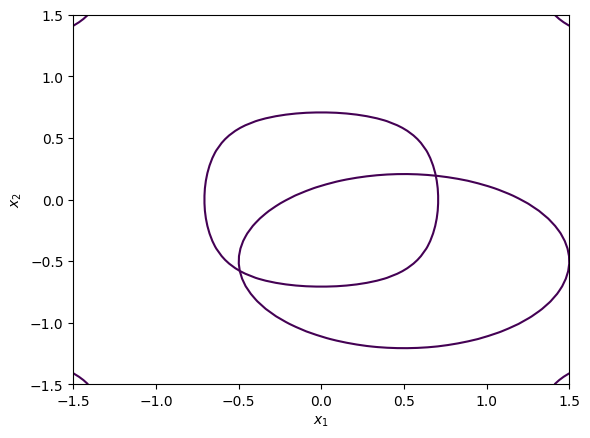

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def f1(x1, x2):
    return (x1 - 0.5) ** 2 + 2 * (x2 + 0.5) ** 2 - 1


def f2(x1, x2):
    return np.cos(x2) * x1**2 + np.cos(x1) * x2**2 - 0.5


fig = plt.figure()
gc = fig.gca()
x1 = np.linspace(-1.5, 1.5, 50)
x2 = np.linspace(-1.5, 1.5, 50)
X1, X2 = np.meshgrid(x1, x2)
gc.contour(x1, x2, f1(X1, X2), [0])
gc.contour(x1, x2, f2(X1, X2), [0])
gc.set_xlabel(r"$x_1$")
gc.set_ylabel(r"$x_2$")

As we can see, the two curves intersect in two locations. Let us see if we can find one of these intersections using Newton's method. Rather than scalar values, we will now deal with a vector unknown:
$$ X = \begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}.
$$
Our residue can also be seen as a vector:
$$
F(X) = \begin{bmatrix}
f_1(X) \\
f_2(X)
\end{bmatrix}.
$$


In [2]:
def F(X):  # Defining the residu and unknown as vectors
    x1, x2 = X
    return np.array([f1(x1, x2), f2(x1, x2)])

Now, we have to have an equivalent of the derivative of $F$. In function of two variables, the differential of the function is defined as such:
$$
g : (x_1, x_2) \rightarrow g(x_1, x_2),
$$
$$
\mathrm{d}g = \frac{\partial g}{\partial x_1}\mathrm{d}x_1 + \frac{\partial g}{\partial x_2}\mathrm{d}x_2,
$$
which can be seen as the following dot product:
$$
\mathrm{d}g =
\begin{bmatrix}
\frac{\partial g}{\partial x_1} & \frac{\partial g}{\partial x_2}
\end{bmatrix}
\cdot
\begin{bmatrix}
\mathrm{d}x_1 \\
\mathrm{d}x_2
\end{bmatrix}
$$
For our case, we have a system consisting of two equations. We could abusively write:
$$
\mathrm{d}F = \begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} \\
\frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2}
\end{bmatrix}
\cdot
\begin{bmatrix}
\mathrm{d}x_1 \\
\mathrm{d}x_2
\end{bmatrix}=
J\cdot \mathrm{d}X,
$$
where $J$ is called the jacobian matrix of the system, playing the same role as the derivative in the 1D case. \
Note that generalization to $n$ dimensions is quite straightforward:
$$
J = \begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \cdots & \frac{\partial f_1}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial f_n}{\partial x_1} & \cdots &\frac{\partial f_n}{\partial x_n}
\end{bmatrix}=
\left( \frac{\partial f_i}{\partial x_j} \right)_{(i,j)}.
$$
Let us implement the jacobian matrix of our system:

In [3]:
def J(X):
    x1, x2 = X

    df1_dx1 = 2 * (x1 - 0.5)
    df1_dx2 = 4 * (x2 + 0.5)
    df2_dx1 = 2 * np.cos(x2) * x1 - np.sin(x1) * x2**2
    df2_dx2 = -np.sin(x2) * x1**2 + 2 * np.cos(x1) * x2

    return np.array([[df1_dx1, df1_dx2], [df2_dx1, df2_dx2]])

Continuing our parallels with the 1D method, the iteration will be the following:
$$
X_{n+1} = X_n - J^{-1}(X_n)\cdot F(X_n).
$$
This of course requires $J(X_n)$ to be non-singular, just as the 1D method required the derivative to be non-zero. \
Evaluation of the convergence will be done through the norm of the residu, with the following convergence criterion for a precision $\varepsilon > 0$:
$$
\| F(X_n)\| \leq \varepsilon
$$

In [4]:
def newton_method(residu, jacobian, initial_guess, tolerance, max_iteration=50):
    X_n = initial_guess
    X = [initial_guess]
    iteration = 0

    while np.linalg.norm(residu(X_n)) > tolerance and iteration < max_iteration:
        X_n -= np.dot(np.linalg.inv(jacobian(X_n)), residu(X_n))

        X.append(X_n.copy())
        iteration += 1
        print(
            "Iteration {}: X_{} = {}, residual norm = {}".format(
                iteration, iteration, X_n, np.linalg.norm(residu(X_n))
            )
        )

    if np.linalg.norm(residu(X_n)) > tolerance:  # Not converged
        print("Did not converge after {} iterations.".format(iteration))
    else:  # Converged
        print("Converged in {} iterations.".format(iteration))

    return np.array(X)

Let us test the algorithm with the following initial guess:
$$
X_0 = \begin{bmatrix}
1 \\
1
\end{bmatrix},
$$
and a tolerance of $10^{-12}$:

Iteration 1: X_1 = [-1.16354061  0.7355901 ], residual norm = 4.873923550407763
Iteration 2: X_2 = [-0.44811073  0.24180988], residual norm = 1.0308400594810303
Iteration 3: X_3 = [-1.08958918 -0.50496602], residual norm = 1.662217912549292
Iteration 4: X_4 = [-0.61732745  0.77567863], residual norm = 3.5129690661173005
Iteration 5: X_5 = [-5.01659984 -1.837438  ], residual norm = 33.57284591095184
Iteration 6: X_6 = [-2.18691142 -1.50287348], residual norm = 8.363108124504286
Iteration 7: X_7 = [-0.53139983 -1.66875248], residual norm = 3.3652219107890797
Iteration 8: X_8 = [-0.65186082 -1.01758013], residual norm = 1.02107086924232
Iteration 9: X_9 = [-0.66900613 -0.58186993], residual norm = 0.4047801709702487
Iteration 10: X_10 = [-0.50439679 -0.59676535], residual norm = 0.035386795906236765
Iteration 11: X_11 = [-0.49395714 -0.57979421], residual norm = 0.0006918466773638073
Iteration 12: X_12 = [-0.49358518 -0.57996463], residual norm = 2.712247182495904e-07
Iteration 13: X_13 =

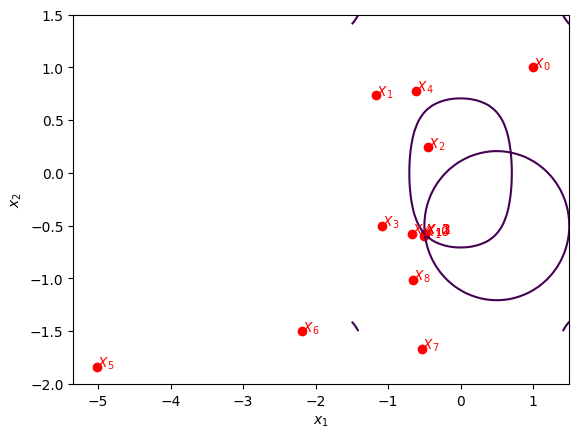

In [5]:
X_0 = [1, 1]
eps = 1e-12

result = newton_method(F, J, X_0, eps)

gc.scatter((result.T)[0], (result.T)[1], c="r")
for i in range(len((result.T)[0])):
    gc.annotate(r"$X_{}$".format(i), (result[i, 0], result[i, 1]), c="r")
fig

Iteration 1: X_1 = [0.83077947 0.25      ], residual norm = 0.3153118504023826
Iteration 2: X_2 = [0.70119693 0.20043714], residual norm = 0.025061800182344454
Iteration 3: X_3 = [0.69291786 0.1938794 ], residual norm = 0.00016580339243585336
Iteration 4: X_4 = [0.6928807  0.19382888], residual norm = 6.712149921298664e-09
Iteration 5: X_5 = [0.6928807  0.19382888], residual norm = 0.0
Converged in 5 iterations.


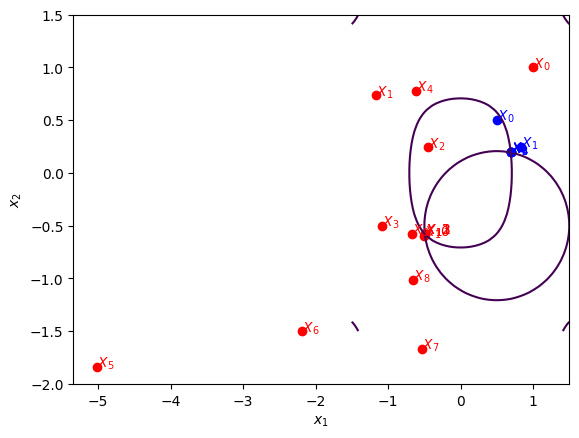

In [6]:
X_0 = [0.5, 0.5]

result = newton_method(F, J, X_0, eps)

gc.scatter((result.T)[0], (result.T)[1], c="b")
for i in range(len((result.T)[0])):
    gc.annotate(r"$X_{}$".format(i), (result[i, 0], result[i, 1]), c="b")
fig

## Bonus: Newton's method with numerical approximation of the jacobian

Calculating the Jacobian matrix of the system can be pretty tedious at times (especially later when dealing with tensorial equations for instance). An alternative way consists in using an numerical approximate of the jacobian obtained by a small perturbation $\eta$. The partial derivatives, components of the jacobian matrix can be approximated as: \
$$
\frac{\partial f_i}{\partial x_j}\left( (\tilde{x}_k)_{1\leq k \leq n}\right) \simeq \frac{ f_i( (\tilde{x_k} + \delta_{jk}\eta)_{1\leq k\leq n}) - f_i( (\tilde{x_k} - \delta_{jk}\eta)_{1\leq k\leq n})}{ 2\eta },
$$
where $\delta_{jk}$ is Kronecker's delta. Let us implement it for our previous case and test it with $x_0 = [1,1]$.

In [7]:
def numerical_J(X, residu, perturbation):
    x1, x2 = X
    return (
        1
        / (2 * perturbation)
        * np.array(
            [
                residu([x1 + perturbation, x2]) - residu([x1 - perturbation, x2]),
                residu([x1, x2 + perturbation]) - residu([x1, x2 - perturbation]),
            ]
        ).T
    )


X_0 = [1, 1]
eta = 1e-9  # Perturbation magnitude for the numerical jacobian

result = newton_method(F, lambda X: numerical_J(X, F, eta), X_0, eps)

Iteration 1: X_1 = [-1.16354098  0.73559022], residual norm = 4.873925375641496
Iteration 2: X_2 = [-0.44811051  0.2418101 ], residual norm = 1.0308403361762342
Iteration 3: X_3 = [-1.08959006 -0.50496631], residual norm = 1.662221073447772
Iteration 4: X_4 = [-0.61732806  0.7756517 ], residual norm = 3.5128313761769663
Iteration 5: X_5 = [-5.01396371 -1.83633989], residual norm = 33.534127392120624
Iteration 6: X_6 = [-2.1861345  -1.50141289], residual norm = 8.351347754237727
Iteration 7: X_7 = [-0.53290208 -1.66633896], residual norm = 3.3536872195338487
Iteration 8: X_8 = [-0.65264404 -1.01581128], residual norm = 1.0183452046258314
Iteration 9: X_9 = [-0.66903454 -0.58033439], residual norm = 0.4040321174125505
Iteration 10: X_10 = [-0.50434962 -0.59743717], residual norm = 0.03587888597659178
Iteration 11: X_11 = [-0.49398101 -0.579788  ], residual norm = 0.0007383384770054459
Iteration 12: X_12 = [-0.49358519 -0.57996465], residual norm = 3.0241302424738754e-07
Iteration 13: X_1

If we look closely at the residual value, we can see that we lost some precision compared to the exact jacobian. However, it did not affect our convergence overall.